In [1]:
# Import the necessary libraries
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xg
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap
import sklearn

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Input dataset
dataset = pd.read_excel("data_grid_demo.xlsx")
dataset.head()
X = dataset.drop("g_r", axis = 1)
y = dataset.g_r

The figure layout has changed to tight


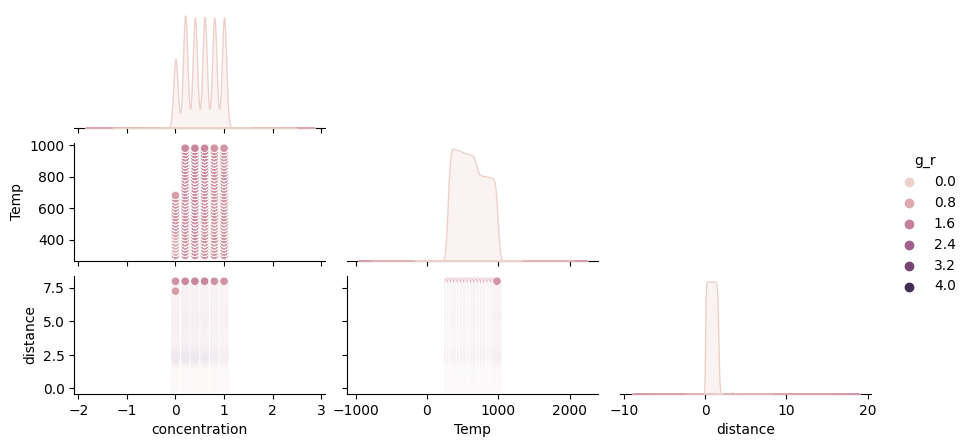

In [3]:
# Show the pairplot
ax=sns.pairplot(dataset, hue="g_r", aspect = 2, height = 1.5, corner=True)
plt.show()

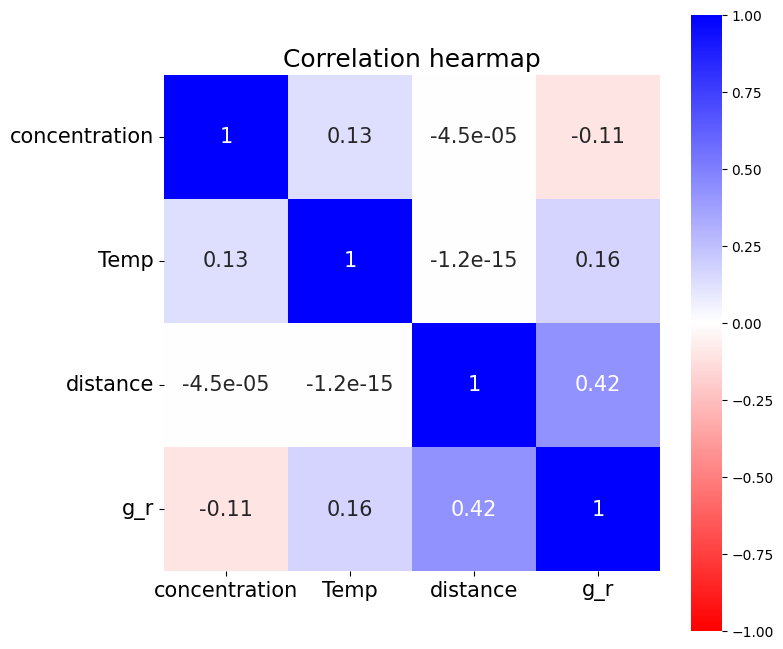

In [4]:
# Show the heatmap matrix
corr = dataset.corr()

plt.figure(figsize=(8, 8))
ax = sns.heatmap(corr, vmin=-1, vmax=1, square=True, annot=True, xticklabels=True, yticklabels=True, annot_kws={"size": 15}, cmap='bwr_r')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15) 
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15, rotation=0) 
plt.title('Correlation hearmap', fontsize=18)
plt.show()

In [5]:
# Build baseline model
X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(X, y, test_size=0.4857, random_state=0)
xg_regressor_b = xg.XGBRegressor(random_state=0, tree_method='gpu_hist')
xg_regressor_b.fit(X_baseline_train, y_baseline_train)
y_baseline_pred = xg_regressor_b.predict(X_baseline_test)
mse_baseline = mean_squared_error(y_baseline_test, y_baseline_pred)
rmse_baseline = mean_squared_error(y_baseline_test, y_baseline_pred, squared=False)
mae_baseline = mean_absolute_error(y_baseline_test, y_baseline_pred)
r2_baseline = r2_score(y_baseline_test, y_baseline_pred)
print(f'Baseline model scores:\nMSE = {mse_baseline:.10f}\nRMSE = {rmse_baseline:.4f}\nMAE = {mae_baseline:.10f}\nR Squared = {r2_baseline:.10f}')

Baseline model scores:
MSE = 0.0059694264
RMSE = 0.0773
MAE = 0.0446181914
R Squared = 0.9891140077


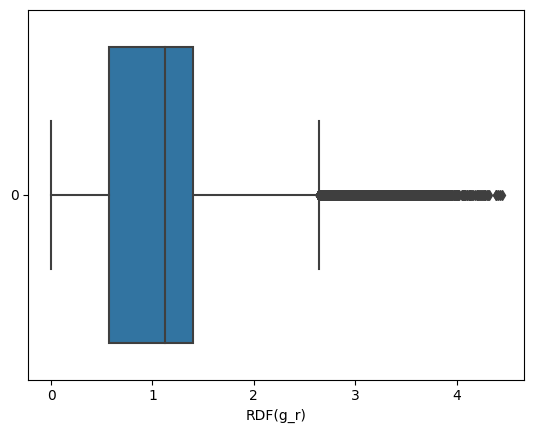

Old Shape:  (97500, 4)
New Shape:  (94070, 4)


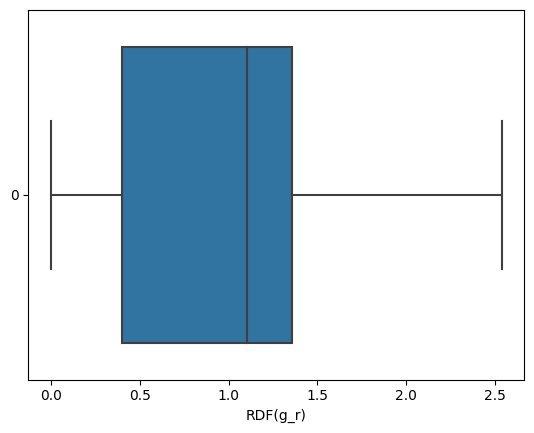

In [6]:
# Data preprocessing
# Plot the old data
sns.boxplot(dataset['g_r'], orient='h')
plt.xlabel('RDF(g_r)')
plt.show()

# Detection outlier
# IQR
Q1 = np.percentile(dataset['g_r'], 25,
                   method = 'midpoint')
 
Q3 = np.percentile(dataset['g_r'], 75,
                   method = 'midpoint')
IQR = Q3 - Q1

print("Old Shape: ", dataset.shape)

# Remove outlier
# Upper bound
upper = np.where(dataset['g_r'] > ((Q3 + 1.5 * IQR)-0.1))
# Lower bound
lower = np.where(dataset['g_r'] < (Q1 - 1.5 * IQR))

dataset.drop(upper[0], inplace = True)
dataset.drop(lower[0], inplace = True)

print("New Shape: ", dataset.shape)

# Plot the new data
sns.boxplot(dataset['g_r'], orient='h')
plt.xlabel('RDF(g_r)')
plt.show()

X = dataset.drop("g_r", axis = 1)
y = dataset.g_r

Tuned XGBoost Regression Parameters: {'learning_rate': 0.15, 'max_depth': 9, 'n_estimators': 200}
Best score is 0.9918330242833775


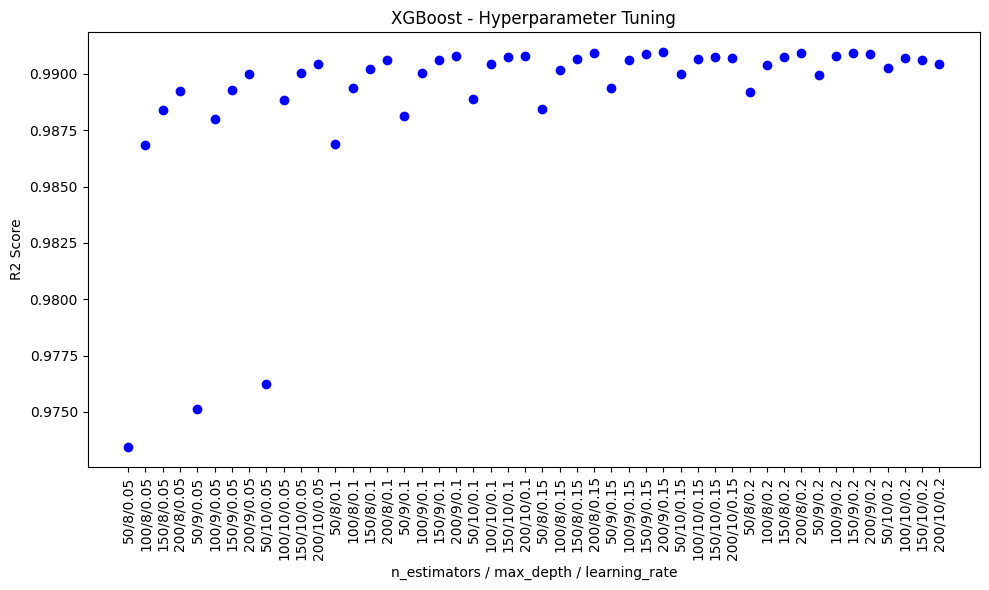

In [7]:
# Hyperparameter tuning 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4857, random_state=0)
xg_regressor = xg.XGBRegressor(random_state=0, tree_method='gpu_hist')

# Define the parameter grid
param_grid = {'n_estimators': [50, 100, 150, 200], 
              'max_depth': [8, 9, 10],
              'learning_rate': [0.05, 0.1, 0.15, 0.2]
             }

# Initialize the grid search object
grid = GridSearchCV(xg_regressor, param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Make predictions on the test set
xgb_best_model = grid.best_estimator_
y_pred = xgb_best_model.predict(X_test)
r2=r2_score(y_test, y_pred)
results=grid.cv_results_
params = results['params']
mean_test_scores = results['mean_test_score']

# Print the tuned parameters and score
print("Tuned XGBoost Regression Parameters: {}".format(grid.best_params_))
print("Best score is {}".format(r2))

# Plot mean_test_score
plt.figure(figsize=(10, 6))
for param, score in zip(params, mean_test_scores):
    n_estimators = param['n_estimators']
    max_depth = param['max_depth']
    learning_rate = param['learning_rate']
    plt.scatter(f"{n_estimators}/{max_depth}/{learning_rate}", score, color='blue')

plt.xlabel('n_estimators / max_depth / learning_rate')
plt.ylabel('R2 Score')
plt.title('XGBoost - Hyperparameter Tuning')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


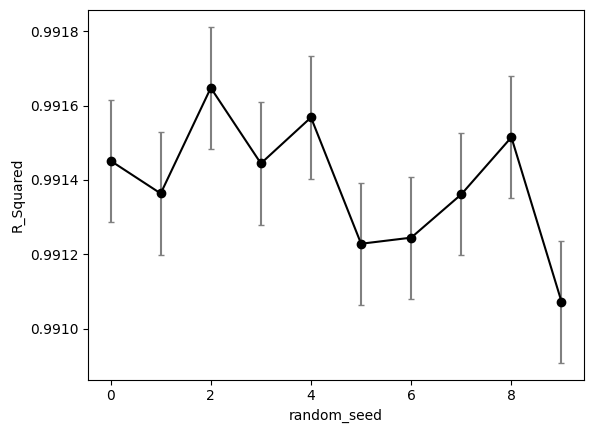

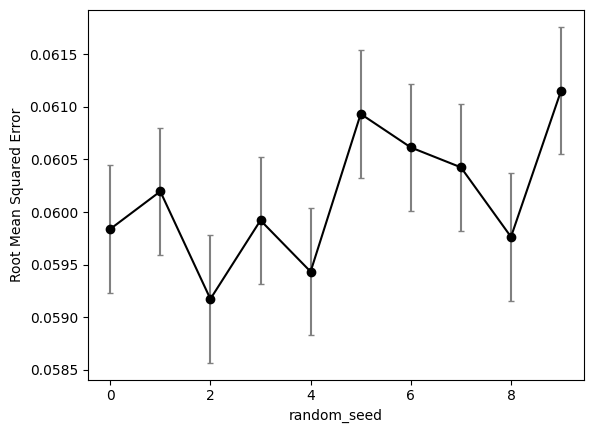

In [8]:
rmses = []
r2s = []
random_seed=np.arange(10)
for i in random_seed:
    X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y, test_size=0.4857, random_state= random.randint(1,100000))
    xgb_r_e = xg.XGBRegressor(objective ='reg:squarederror',
                    n_estimators = 100, max_depth=9, learning_rate=0.15, seed = random.randint(1,100000), tree_method='gpu_hist')
    xgb_r_e.fit(X_train_e, y_train_e)
    y_pred_e = xgb_r_e.predict(X_test_e)
    rmse = mean_squared_error(y_test_e, y_pred_e, squared=False)
    rmses.append(rmse)
    r2 = r2_score(y_test_e, y_pred_e)
    r2s.append(r2)

# visualize the results
plt.figure()
plt.errorbar(random_seed, r2s, yerr = np.std(r2s), fmt='o', color='black', ecolor='gray',capsize=2)
plt.plot(random_seed, r2s, color='black')
plt.xlabel('random_seed')
plt.ylabel('R_Squared')
plt.show()

plt.figure()
plt.errorbar(random_seed, rmses, yerr = np.std(rmses), fmt='o', color='black', ecolor='gray',capsize=2)
plt.plot(random_seed, rmses, color='black')
plt.xlabel('random_seed')
plt.ylabel('Root Mean Squared Error')
plt.show()

In [9]:
print(max(r2s))
print(min(r2s))
print(max(rmses))
print(min(rmses))

0.9916475710973591
0.9910726944006929
0.061154651538386784
0.059174268904955


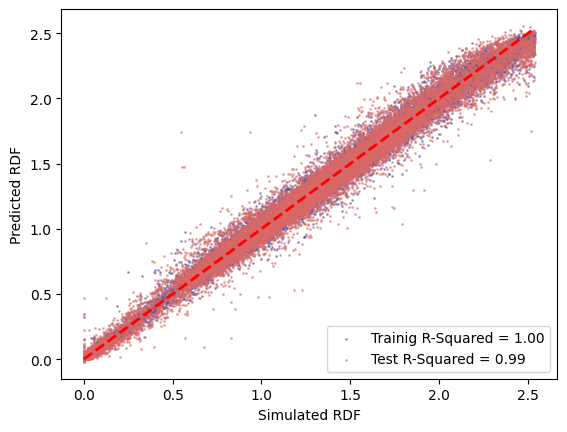

Mean Squared Error: 0.003671189585790701
Root Mean Squared Error: 0.06059034234752846
Mean Absolute Error: 0.03592096677053535
R-squared: 0.9912681020451549


In [10]:
# Evaluate the model's performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4857, random_state=0)
xg_regressor = xg.XGBRegressor(objective ='reg:squarederror', n_estimators=100, max_depth=9, learning_rate=0.15, random_state=0, tree_method='gpu_hist')
xg_regressor.fit(X_train, y_train)

y_train_pred= xg_regressor.predict(X_train)
y_test_pred = xg_regressor.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

plt.scatter(y_train, y_train_pred, alpha=0.5, label = f'Trainig R-Squared = {r2_train:.2f}', s =1, c='#58539f')
plt.scatter(y_test, y_test_pred, alpha=0.5, label = f'Test R-Squared = {r2_test:.2f}', s =1, c='#d86967' )
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red', linewidth=2)
plt.xlabel('Simulated RDF')
plt.ylabel('Predicted RDF')
legend = plt.legend(loc='lower right', fontsize='medium')
plt.show()

y_pred = xg_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)


In [11]:
y_pred_all=xg_regressor.predict(X)
data_pred = pd.DataFrame(y_pred_all)
dataset0 = dataset.copy()
dataset0['g_r'] = y_pred_all
print(dataset0)

       concentration  Temp  distance       g_r
0                0.0   300     0.008  0.002786
1                0.0   300     0.024  0.002786
2                0.0   300     0.040 -0.000177
3                0.0   300     0.056 -0.000177
4                0.0   300     0.072 -0.000553
...              ...   ...       ...       ...
97495            1.0   980     7.928  1.204824
97496            1.0   980     7.944  1.204824
97497            1.0   980     7.960  1.204620
97498            1.0   980     7.976  1.204620
97499            1.0   980     7.992  1.204620

[94070 rows x 4 columns]


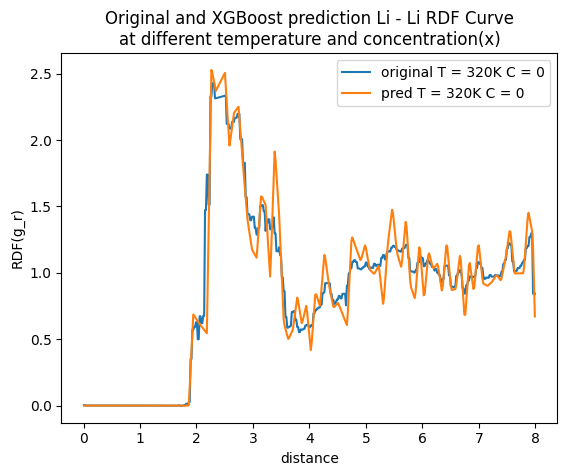

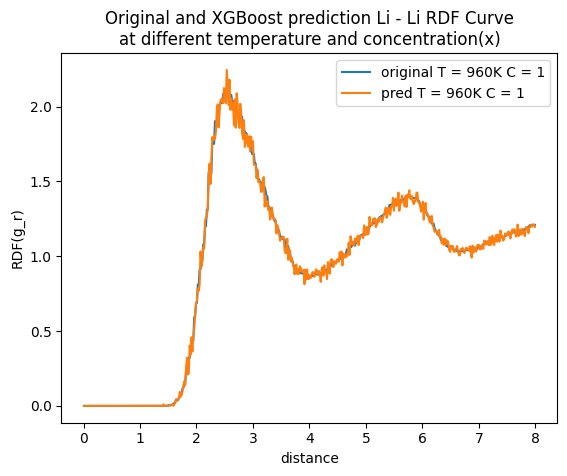

In [15]:
Tp = [320, 960]
for i in [0, 1]:
    data_pred_ploti=dataset0.loc[(dataset0['Temp'] == Tp[i]) & (dataset0['concentration'] == i)]
    data_ploti=dataset.loc[(dataset0['Temp'] == Tp[i]) & (dataset0['concentration'] == i)]
    plt.plot(data_pred_ploti['distance'], data_pred_ploti['g_r'], label=f'original T = {Tp[i]}K C = {i}')
    plt.plot(data_ploti['distance'], data_ploti['g_r'], label=f'pred T = {Tp[i]}K C = {i}')
    plt.legend(loc='upper right', fontsize='medium')
    plt.ylabel('RDF(g_r)')
    plt.xlabel('distance')
    plt.title('Original and XGBoost prediction Li - Li RDF Curve\nat different temperature and concentration(x)')
    plt.show()

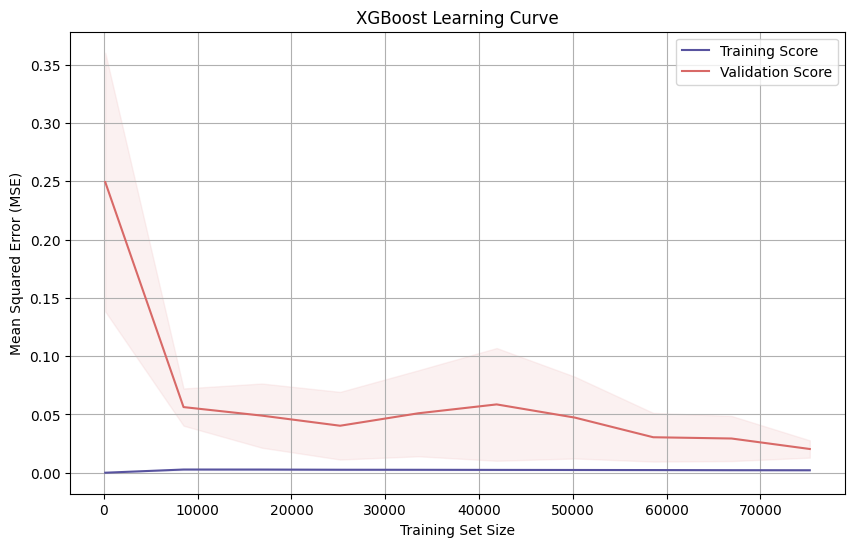

In [13]:
# Plot Learning Curve
train_sizes = np.linspace(0.002, 1.0, 10)
train_sizes, train_scores, val_scores = learning_curve(
    xg_regressor, X, y, cv=5, train_sizes=train_sizes, scoring='neg_mean_squared_error', random_state=0
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = -np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Score', color='#58539f')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='#bbbbd6')
plt.plot(train_sizes, val_scores_mean, label='Validation Score', color='#d86967')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.2, color='#eebabb')

plt.title('XGBoost Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
